In [1]:
import qutip as qt
import QNN as qnn
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

2024-09-13 05:18:42.685629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 05:18:42.685648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 05:18:42.686411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [2]:
df = pd.read_csv('Params/Function_5/parameters_fold_1.csv')

for i in range(2):  # Adjust the range as needed
    # Create the tuple column
    df[f'Layer{i}_bx'] = df[[f'Layer{i}_bx', f'Layer{i}_bp']].apply(tuple, axis=1)
    
    # Drop the original 'bp' column
    df = df.drop(columns=[f'Layer{i}_bp'])
    df = df.rename(columns={f'Layer{i}_bx': f'Layer{i}_bx_bp'})

In [3]:
def state(x, dim, epoch, layer, sublayer, params = df):
    
    psi = qnn.get_vacuum_state_tf(dim)
    enc = qnn.displacement_operator(dim, x, 0.0)
    psi = tf.matmul(enc, psi)
    
    if epoch == 0:
        return psi_enc
    else:
        N = layer*sublayer
        P = []
        for i in range(1,N+1):
            P.append(df[df.columns[i]][epoch+1])

    ops = [qnn.rotation_operator, qnn.squeezing_operator, qnn.rotation_operator, qnn.displacement_operator, qnn.kerr_operator]
    num_ops = len(ops)
    for i in range(N):
        op = ops[i % num_ops]
        if op == qnn.displacement_operator:
            psi = tf.matmul(op(dim, *P[i]), psi)
        else:
            psi = tf.matmul(op(dim, P[i]), psi)    

    psi = tf.squeeze(psi, axis=-1)
    psi = psi.numpy()
    
    return qt.Qobj(psi)

In [9]:
from matplotlib import cm

def wigner_plot(x, dim = 20, epoch = 0, layer = 0, sublayer = 0):
    psi = state(x, dim, epoch, layer, sublayer)

    xvec = np.linspace(-10, 10, 500)
    W = qt.wigner(psi, xvec, xvec)
    wmap = qt.wigner_cmap(W)  # Generate Wigner colormap

    nrm = mpl.colors.Normalize(-W.max(), W.max())
    wplot = plt.contourf(xvec, xvec, W, 100, cmap=wmap)  # Apply Wigner colormap

    plt.title("Wigner Colormap")
    cb2 = plt.colorbar(wplot)

    plt.tight_layout()

    plt.show()

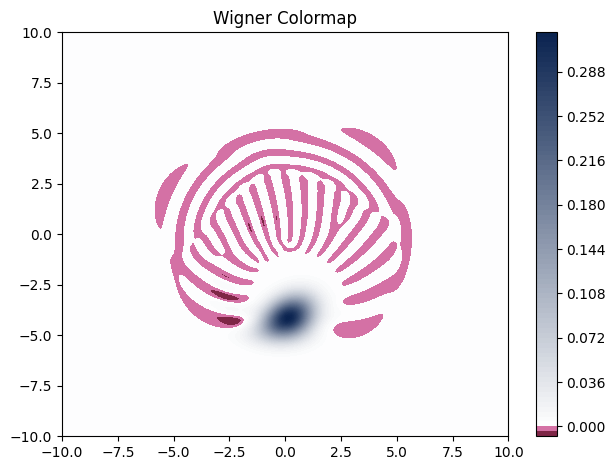

In [10]:
wigner_plot(-2.8, epoch = 175, layer = 2, sublayer = 5)